# Introduction

2020 is an special and eventful year with the coronavirus spreading across countries since January and the U.S Presidential Election occuring in November. The two candidates, Donald Trump and Joe Biden, have undoubtedly utilized Twitter as an avenue to increase their publicity, connect with supporters, and reach out to potential voters. We are interested in investigating and comparing the similarities and differences between their Twitter activity, both in the context of the election and more broadly, in the past year. This has significant implications as political parties, candidates, and celebrities have increasingly placed more effort into growing their social media accounts. Thus, a question that arises is: how does one's online activity influence his or her so-called popularity or the level of engagement online? Moreover, what are the attributes of successful social media strategies?

Our revised research question, aiming at answering the above questions, is: how does the Twitter activity of Biden and Trump differ? We will look at how their activities change over time as election nears, as well as behaviors throughout the entire observation period. These investigations would shed light on whether and how certain behaviors or attributes (time of day, length, sentiment) affect popularity, as well as how the candidates' behaviors change as election day nears.

# Data Description

The data collection idea was inspired by a data analysis project by Eric Bruin posted on Kaggle that compared tweets between Donald Trump and Hilary Clinton in 2016 (Bruin). Similar to Bruin, we are interested in looking at “real social media data” and looking for relationships within the data. Bruin wrote a script in R to extract tweets from each account. We developed a similar approach to mine the tweets. First, we had to sign up for a Twitter Developer account in order to gain access to Twitter API keys. Once our applications were approved, we installed the Tweepy API. The Tweepy API allowed us to call the Twitter API functions within a Jupyter notebook using Python. From there, we developed our own script that was able to extract tweets from a given user. We collected 3083 tweets from Joe Biden and 1661 tweets from Donald Trump. We hope to collect more tweets from Trump’s twitter account. Unfortunately when mining Trump’s account, the API stalled once it reached ~1600 tweets. The script created an array of tweets. Then using the pandas dataframe, we wrote a CSV file that contained all the data. Each observation represents a tweet; during the collection phase we specifically filtered out retweets so that the dataset would only contain tweets generated by the user. Each tweet has an id, full text, entities (ex: hashtags), created at date, number of favorites (likes), number of retweets, language, geolocation (if available), and an in reply attribute (indicates if a tweet was in response to another account). The Twitter API allows for a maximum collection of 3200 tweets. For Joe Biden his tweets date back to almost a year ago, while Trump’s tweets only go back to July. This is reasonable because Trump is more active on Twitter.  The raw data source is provided in the CSV files that are part of our github repository (2950ProjectGitHubRepository).

# Data Limitations

As discussed in the data description section, the biggest limitation we faced was having a limit of ~3200 tweets from a Twitter account. This is a rule of the Twitter API, which can be bypassed by paying for premium APIs. That was the main limitation we faced, each tweet object (Tweepy Status object) fortunately contains a good amount of information that allows us to perform different and interesting analysis. 

# Pre-registration

First, we would perform a cluster analysis plotting time of day against number of likes, in order to find out if posting at a certain time is associated with more likes. This would enableus to find out if posting at a certain time is more advantageous for a candidate, and whether or not candidates recognized and utilized this to their advantage. However, we recognize the limitation that voters' interactions on Twitter may not be generalized to general social media use.

Next, we would compare Trump and Biden's Twitter activities as election nears, plotting various variables against time. These variables include frequency of tweets, number of likes, number of retweets, number of words...etc. This would enable us to see whether and how the candidates' activities and popularity changed over time.

Lastly, we aim to perform our optional analysis: a sentiment analysis of each candidates' tweets. We would first extract the most popular words from Biden and Trump's tweets respectively and using logistic regression to predict number of likes using keywords, in order to see if the usage of certain keywords is associated with more likes. Then, we would sentiment-code the keywords and compare the two candidates' overall sentiments of Tweets. This would reveal important characteristics of the candidates' Twitter activity that we otherwise could not obtain through summary statistics and regression analysis alone.

# Data Import and Preparations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics
import nltk
import seaborn as sns
from datetime import date
from string import punctuation
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/sunil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sunil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Cleaning 

We collected the data through the Twitter API, we search for a userID and the amount of tweets that we want, and the API gives us tweets back in the form of twitter objects. Not only do the tweets have the text, but they also have a load of other supplementary data. The twitter object is given back in JSON format. To create the dataset that we have, we chose a few of the data points that we wanted from each object and used lists to combine them into a dataframe. After doing this we had a dataframe generated that contained all of the data attributes that we wanted. The data points that we kept for our dataframe are: the id number, the full text, entities data, date and time created, favourites, retweets, language, geo location and who, if anyone, the tweet was in reply to.

#### Importing Biden's data into a dataframe, we print the top-5 rows of each column.

In [3]:
biden = pd.read_csv("biden_tweets.csv")


#### Importing Trump's data into a dataframe, we print the top-5 rows of each column.

In [4]:
trump = pd.read_csv("trump_tweets.csv")

#### Next, we convert string into datetime format and store the information in a new column.

#### Then, we create a time of day column which has four possible values – morning, afternoon, evening, and night – and assign a corresponding value for each tweet.

In [168]:
# create date time column 
biden["date"] = pd.to_datetime(biden["created_at"], format = "%Y-%m-%d %H:%M:%S")
trump["date"] = pd.to_datetime(trump["created_at"], format = "%Y-%m-%d %H:%M:%S")
# create time of day column 
# morning = 5 am : 12 pm = any hour value from 5 to 11 
# afternoon = 12 pm : 5 pm = any hour value from 12 to 16 
# evening = 5 pm : 10 pm = any hour value from 17 to 22 
# night = 10 pm : 5 am = any hour value from 23 to 4 (23,0,1,2,3,4) <- wrap around
def time_of_day (x):
    hour = x.hour 
    if  5 <= hour <= 11: 
        return "morning"
    elif 12 <= hour <= 16:
        return "afternoon"
    elif 17 <= hour <= 22:
        return "evening"
    else:
        return "night"

# column for hour of day tweet posted 
def hour(x):
    return x.hour 

# create column for tweet word count  
def tweet_length (x):
    return len(x.split())

# create columns that contain series of night vs day where night = 1 , day = 0 
day_night_map = {"morning":0, "afternoon":0, "evening":1, "night":1}


def to_election_norm(x, dates):
    x['days_to_election'] = date(2020, 11, 3) - dates.dt.date
    # convert from day object to int  
    x['days_to_election'] = x['days_to_election'].dt.days

def to_election_group(x, dates):
    x['days_to_election'] = date(2020, 11, 3) - dates
    # convert from day object to int  
    x['days_to_election'] = x['days_to_election'].dt.days

In [169]:
# cell for applying functions and actually creating the columns 
biden['time_of_day'] = biden['date'].map(time_of_day)
biden['tweet_length'] = biden['full_text'].map(tweet_length) # word count of each tweet 
biden['hour'] = biden['date'].map(hour)
biden['day_or_night'] = biden['time_of_day'].map(day_night_map)

trump['time_of_day'] = trump['date'].map(time_of_day)
trump['tweet_length'] = trump['full_text'].map(tweet_length)
trump['hour'] = biden['date'].map(hour)
trump['day_or_night'] = trump['time_of_day'].map(day_night_map)

# create grouped_dfs by day 

bidenbyday = (biden['date'].dt.date).value_counts().rename_axis('unique_dates').reset_index(name='tweets_each_day')
trumpbyday= (trump['date'].dt.date).value_counts().rename_axis('unique_dates').reset_index(name='tweets_each_day')


to_election_norm(biden, biden['date'])
to_election_norm(trump, trump['date'])
# for bidenbyday and trumpbyday df 
to_election_group(bidenbyday, bidenbyday['unique_dates'])
to_election_group(trumpbyday, trumpbyday['unique_dates'])

#### Converting Tweet dates from string into datetime format prepares for our subsequent analysis. 
#### We obtained Biden and Trump tweets by day from the following source: https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe

Cleaned up to_election computations, ready to be moved to main data cleaning section

# Exploratory Data Analysis

#### We first compute summary statistics for the "full_text", "favourite", and "retweet" columns.

In [170]:
# Get summary statistics 

def summ_stat(x, names):
    total_words = 0
    word_counts_list = []

    for tweet in x["full_text"]:
        tweet_length = tokenize(tweet)
        word_counts_list.append(tweet_length)                 
        total_words += tweet_length
    # word count summ stats 
    print(names + " words tweeted: " + "{:.0f}".format(total_words))
    mean_wordcount = np.mean(word_counts_list)
    print("Mean number of words in " + names + " tweets: " + "{:.2f}".format(mean_wordcount))
    median_wordcount = np.median(word_counts_list)
    print("Median number of words in " + names + ": " + "{:.2f}".format(median_wordcount))
    mode_wordcount = statistics.mode(word_counts_list)
    print("Mode number of words in " + names + " tweets: " + "{:.0f}".format(mode_wordcount))
    minimum_words = min(word_counts_list)
    print("The least number of words " + names + " used in a tweet was: " + "{:.0f}".format(minimum_words))
    maximum_words = max(word_counts_list)
    print("The most number of words " + names + " used in a tweet was: " + "{:.0f}".format(maximum_words))
    stddev_wordcount = np.std(word_counts_list)
    print("Standard deviation of number of words in " + names + " tweets: " + "{:.2f}".format(stddev_wordcount))
    
    # favorites stats 
    total_favorites = x["favourite"].sum()
    print(names + " total tweet favorites count: " + "{:.0f}".format(total_favorites))
    mean_favorites = x['favourite'].mean()
    print("Mean number of favorites for " + names + " tweets: " + "{:.2f}".format(mean_favorites))
    median_favorites = x['favourite'].median()
    print("Median number of favorites for " + names + " tweets: " + "{:.2f}".format(median_favorites))
    # mode not useful because of wide range of favourite values 
    minimum_favorites = x['favourite'].min()
    print("The least number of favorites a " + names + " tweet received was: " + "{:.0f}".format(minimum_favorites))
    maximum_favorites = x['favourite'].max()
    print("The most number of favorites a " + names + " tweet received was: " + "{:.0f}".format(maximum_favorites))
    stddev_favorites = x['favourite'].std()
    print("Standard deviation of number of favorites for " + names + " tweets: " + "{:.2f}".format(stddev_favorites))
    
    # retweet stats 
    total_retweets = x["retweets"].sum()
    print(names + " retweets: " + "{:.0f}".format(total_retweets))
    mean_retweets = x['retweets'].mean()
    print("Mean number of retweets for " + names + " tweets: " + "{:.2f}".format(mean_retweets))
    median_retweets = x['retweets'].median()
    print("Median number of retweets for " + names + " tweets: " + "{:.2f}".format(median_retweets))
    minimum_retweets = x['retweets'].min()
    print("The least number of retweets a " + names + " tweet received was: " + "{:.0f}".format(minimum_retweets))
    maximum_retweets = x['retweets'].max()
    print("The most number of retweets a " + names + " tweet received was: " + "{:.0f}".format(maximum_retweets))
    stddev_retweets = x['retweets'].std()
    print("Standard deviation of number of retweets for each " + names + " tweet: " + "{:.2f}".format(stddev_retweets))
    
    # lang stats 
    language_counts = x["language"].value_counts()
    print("Raw number of " + names + " tweets in each language: " + "\n" + str(language_counts))
    # print("Percent of tweets in each language: " + "\n" + str(100 * language_counts / len(x.index))

summ_stat(biden, 'Biden')
print('\n')
summ_stat(trump, 'Trump')
# maybe put this in dataframe to make it easier to read / access information 
# NEED TO EXPLAIN WHY CERTAIN TRUMP TWEETS HAVE 0 FAVOURITES 
# perecentage stat in lang stats is redundant 

Biden words tweeted: 100838
Mean number of words in Biden tweets: 32.70
Median number of words in Biden: 35.00
Mode number of words in Biden tweets: 43
The least number of words Biden used in a tweet was: 1
The most number of words Biden used in a tweet was: 59
Standard deviation of number of words in Biden tweets: 12.75
Biden total tweet favorites count: 146530712
Mean number of favorites for Biden tweets: 47513.20
Median number of favorites for Biden tweets: 19678.50
The least number of favorites a Biden tweet received was: 34
The most number of favorites a Biden tweet received was: 1890801
Standard deviation of number of favorites for Biden tweets: 92519.77
Biden retweets: 27712385
Mean number of retweets for Biden tweets: 8985.86
Median number of retweets for Biden tweets: 4409.00
The least number of retweets a Biden tweet received was: 11
The most number of retweets a Biden tweet received was: 327830
Standard deviation of number of retweets for each Biden tweet: 15353.01
Raw numbe

#### Next, we compare histograms plotting Biden and Trump's posts' certain attributes against number of posts in order to see how their Twitter activities differ from one another in length, time, and sentiment, as well as how well-received their activities are.

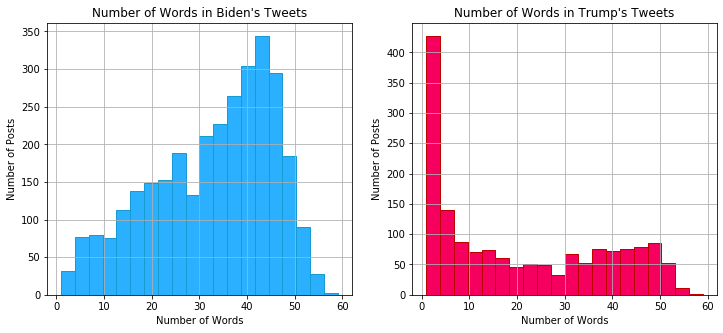

In [172]:
# Number of words

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(biden['tweet_length'], facecolor = '#2ab0ff', edgecolor='#169acf', bins = 20)
ax1.set_title("Number of Words in Biden's Tweets")
ax1.set_xlabel("Number of Words")
ax1.set_ylabel("Number of Posts")
ax1.grid(True)

ax2.hist(trump['tweet_length'], facecolor = "#f5005f", edgecolor='#bd0000', bins = 20)
ax2.set_title("Number of Words in Trump's Tweets")
ax2.set_xlabel("Number of Words")
ax2.set_ylabel("Number of Posts")
ax2.grid(True)

plt.show()

As seen in the side-by-side histograms above comparing the number of words in Biden's and Trump's tweets, Biden's distribution clearly has a higher median with a tail to the left. On the contrary, Trump's distribution exhibits a smaller median with a tail to the right. This signifies that on average, Biden posts longer tweets whereas a majority of Trump's tweets are short (0-5 words had an abnormally high distribution compared to other categories).

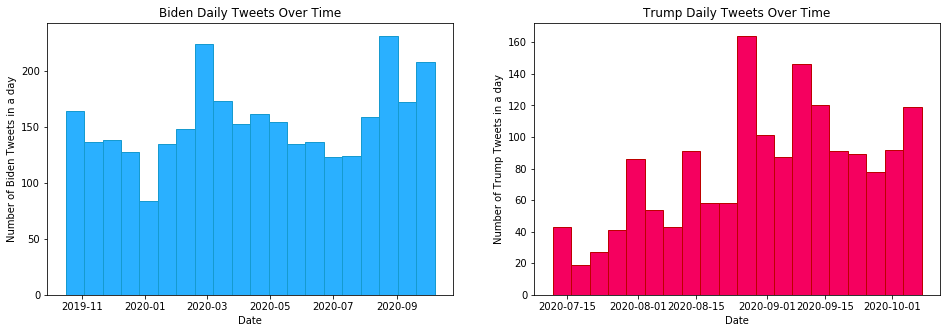

In [173]:
# Tweets per day

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.hist(biden['date'], facecolor = '#2ab0ff', edgecolor='#169acf', bins = 20)
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Biden Tweets in a day')
ax1.set_title("Biden Daily Tweets Over Time")


ax2.hist(trump['date'], facecolor = "#f5005f", edgecolor='#bd0000', bins = 20)
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Trump Tweets in a day')
ax2.set_title("Trump Daily Tweets Over Time")

plt.show()

As seen above, Biden seemed to post roughly the same amount back in November 2019 and September 2020. However, it must be noted that we collected Tweets of Biden throughout a longer period of time since November 2019 whereas we collected Trump's tweets since July 2020 due to the availability of data. This is a potential limitation that will be addressed later on. In order to allow for similar comparisons, we plot Biden and Trump's daily tweets over time from the same period from July to October 2020 below.

#### Next, we plot the number of favourites of each candidate against number of posts, obtaining results that are highly concentrated to the left with some upper outliers (see appendix). To address this and reveal more meaningful relationships between the two variables, we log the number of favourites and plot against number of posts:

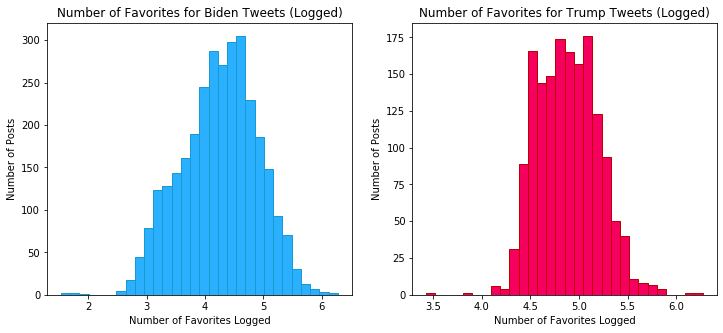

In [196]:
# Favorites logged

# biden_favouritelogged=biden.copy()
# biden_favouritelogged['favourite']=np.log10(biden_favouritelogged['favourite'])
# biden_favouritelogged=biden_favouritelogged.replace([np.inf, -np.inf], np.nan)
# trump_favouritelogged=trump.copy()
# trump_favouritelogged['favourite']=np.log10(trump_favouritelogged['favourite'])
# trump_favouritelogged=trump_favouritelogged.replace([np.inf, -np.inf], np.nan)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(np.log10(biden["favourite"]), bins = 30, facecolor = '#2ab0ff', edgecolor='#169acf')
ax1.set_title("Number of Favorites for Biden Tweets (Logged)")
ax1.set_xlabel("Number of Favorites Logged")
ax1.set_ylabel("Number of Posts")

nozeros = trump[trump['favourite'] > 0]
ax2.hist(np.log10(nozeros['favourite']), bins = 30, facecolor = "#f5005f", edgecolor='#bd0000')
ax2.set_title("Number of Favorites for Trump Tweets (Logged)")
ax2.set_xlabel("Number of Favorites Logged")
ax2.set_ylabel("Number of Posts")

plt.show()


#### As seen above, this gives a much more meaningful view of the relationship bewteen the two variables. It seems that both candidates' plots exhibit an approximately normal distribution with a few lower outliers and a longer tail to the right. This suggests that overall the distribution of number of favourites is quite even and similar. However, since these are logged graphs, we note that they only reflect relative as opposed to absolute distributions. We proceed to plot number of retweets against number of posts.

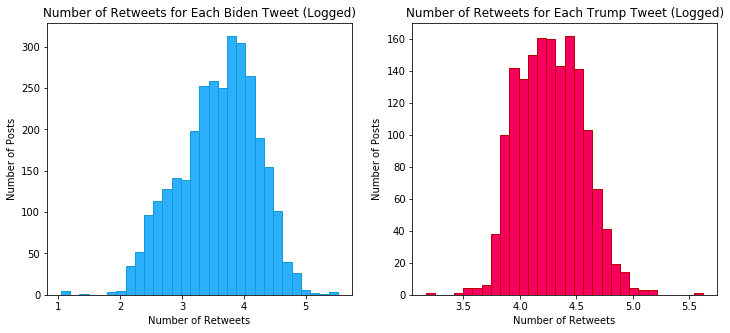

In [197]:
# Retweets logged

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(np.log10(biden["retweets"]), bins = 30, facecolor = '#2ab0ff', edgecolor='#169acf')
ax1.set_title("Number of Retweets for Each Biden Tweet (Logged)")
ax1.set_xlabel("Number of Retweets")
ax1.set_ylabel("Number of Posts")

nozeros = trump[trump['retweets'] > 0]
ax2.hist(np.log10(nozeros["retweets"]), bins = 30, facecolor = "#f5005f", edgecolor='#bd0000')
ax2.set_title("Number of Retweets for Each Trump Tweet (Logged)")
ax2.set_xlabel("Number of Retweets")
ax2.set_ylabel("Number of Posts")

plt.show()

#### As seen above, there also is not any major difference in the distribution of number of retweets each candidate received. Trump's distribution, however, does seem more normal than Biden's, which seems more centered to the right, suggesting a greater number of posts that are retweeted more.

#### Next, we display side-by-side boxplots comparing Biden and Trump's number of words in tweets. As shown below, Biden clearly has more words on average than Trump: his plot's Q1, Q3, as well as median are all above Trump's, giving a clear indication that his tweets are longer in length. Noticeably, the median for Trump's tweets lies at around 15 words and around 35 for Biden's tweets – Biden's median is more than twice the Trump's median!

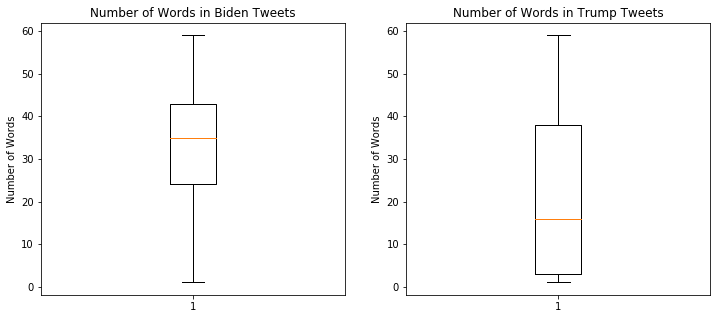

In [176]:
# Number of Words

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.boxplot((biden["tweet_length"]))
ax1.set_title("Number of Words in Biden Tweets")
ax1.set_ylabel("Number of Words")

ax2.boxplot(trump["tweet_length"])
ax2.set_title("Number of Words in Trump Tweets")
ax2.set_ylabel("Number of Words")

plt.show()

#### We see the same pattern in histogram distributions: Trump's plot has a significant peak at 0-5 words, matching the low Q1 and median seen in the boxplot above. In contrast, Biden's distribution has a tail to the left, suggesting a higher median and reflected by the slightly greater distance between median and Q1, where distance suggests sparcity and thus fewer observations.

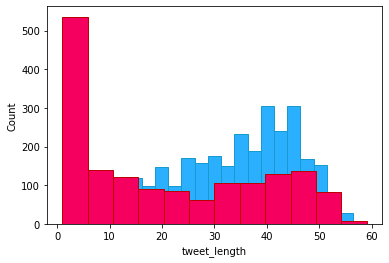

In [198]:
# tweet length differences between Trump and Biden 
sns.histplot(x='tweet_length', facecolor = '#2ab0ff', edgecolor='#169acf', data = biden)
sns.histplot(x='tweet_length',  facecolor = "#f5005f", edgecolor='#bd0000', data = trump)
plt.show()

#### We then plotted number of words against number of favourites, expecting an association between the two variables. However, as shown in the scatterplots below, there does not seem to be a clear relationship between the two. The distribution seems flat – the number of favourites does not vary substantially as number of words changes.

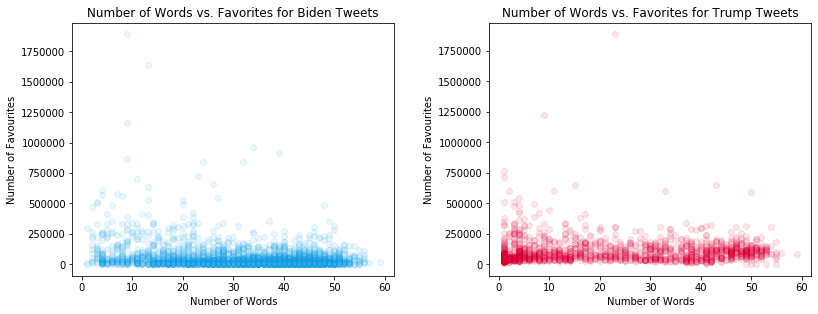

In [199]:
# Number of Words vs. Favorites

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x = "tweet_length", y = "favourite", data= biden, alpha = 0.1, facecolor = '#2ab0ff', edgecolor='#169acf')
ax1.set_title("Number of Words vs. Favorites for Biden Tweets")
ax1.set_xlabel("Number of Words")
ax1.set_ylabel("Number of Favourites")

ax2.scatter(x = 'tweet_length', y = 'favourite', data = trump, alpha = 0.1, facecolor = "#f5005f", edgecolor='#bd0000')
ax2.set_title("Number of Words vs. Favorites for Trump Tweets")
ax2.set_xlabel("Number of Words")
ax2.set_ylabel("Number of Favourites")

fig.tight_layout(pad=3.0)
plt.show()

#### Continuing, we plot number of favourites logged versus number of retweets logged, obtaining a pattern that matches with our expectations: there is a strong positive association between the two, suggesting that as number of favourites increases, so does the number of retweets. We note that the relationship is one of association as opposed to cause-and-effect. We merely observe that the relationship tend to exist between the two variables, but that doesn't mean that one causes the other.

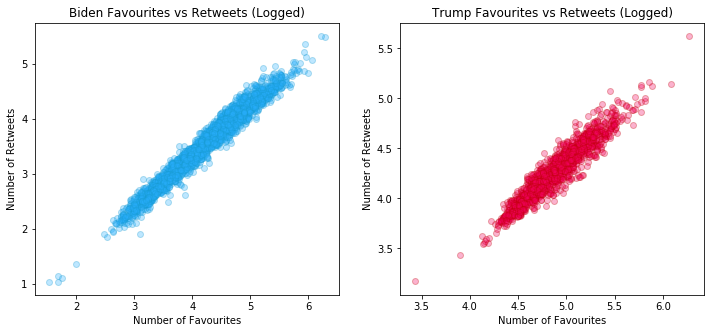

In [200]:
# Logged favorites vs. retweets

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x = np.log10(biden['favourite']), y = np.log10(biden['retweets']), alpha=0.3, facecolor = '#2ab0ff', edgecolor='#169acf')
ax1.set_xlabel('Number of Favourites')
ax1.set_ylabel('Number of Retweets')
ax1.set_title('Biden Favourites vs Retweets (Logged)')

fav_filter = trump[trump['favourite'] > 0]
retweet_filter = trump[trump['retweets'] > 0]
ax2.scatter(x = np.log10(fav_filter['favourite']), y = np.log10(retweet_filter['retweets']), alpha=0.3, facecolor = "#f5005f", edgecolor='#bd0000')
ax2.set_xlabel('Number of Favourites')
ax2.set_ylabel('Number of Retweets')
ax2.set_title('Trump Favourites vs Retweets (Logged)')

plt.show()

# Analysis 2

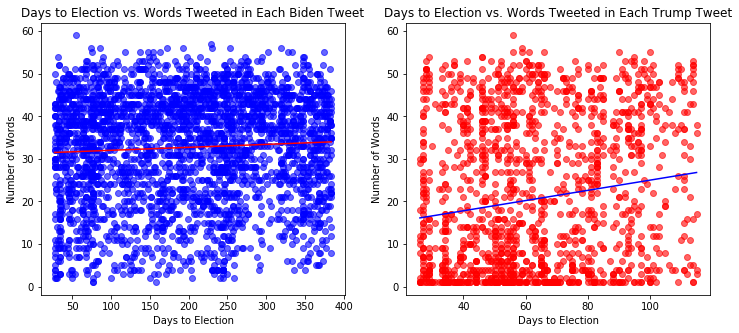

Biden regression coefficient: 0.01
Biden test statistic for regression slope: 3.18
Biden p-value for regression slope test: 0.001
Trump regression coefficient: 0.12
Trump test statistic for regression slope: 6.17
Trump p-value for regression slope test: 0.000


/Users/sunil/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [180]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

b_days_words_model = linear_model.LinearRegression().fit(biden[["days_to_election"]], biden["tweet_length"])
b_days_words_predict = b_days_words_model.predict(biden[["days_to_election"]])

ax1.scatter(biden["days_to_election"], biden["tweet_length"], alpha = 0.6, color = "blue")
ax1.plot(biden["days_to_election"], b_days_words_predict, c = "red")
ax1.set_title("Days to Election vs. Words Tweeted in Each Biden Tweet")
ax1.set_xlabel("Days to Election")
ax1.set_ylabel("Number of Words")

t_days_words_model = linear_model.LinearRegression().fit(trump[["days_to_election"]], trump["tweet_length"])
t_days_words_predict = t_days_words_model.predict(trump[["days_to_election"]])

ax2.scatter(trump["days_to_election"], trump["tweet_length"], alpha = 0.6, color = "red")
ax2.plot(trump["days_to_election"], t_days_words_predict, c = "blue")
ax2.set_title("Days to Election vs. Words Tweeted in Each Trump Tweet")
ax2.set_xlabel("Days to Election")
ax2.set_ylabel("Number of Words")

plt.show()

b_days_words_est = sm.OLS(biden["tweet_length"], sm.add_constant(biden[["days_to_election"]]))
b_days_words_est2 = b_days_words_est.fit()
# print(b_days_words_est2.summary())
print("Biden regression coefficient: " + "{:.2f}".format(b_days_words_est2.params[1]))
print("Biden test statistic for regression slope: " + "{:.2f}".format(b_days_words_est2.tvalues[1]))
print("Biden p-value for regression slope test: " + "{:.3f}".format(b_days_words_est2.pvalues[1]))

t_days_words_est = sm.OLS(trump["tweet_length"], sm.add_constant(trump[["days_to_election"]]))
t_days_words_est2 = t_days_words_est.fit()
print("Trump regression coefficient: " + "{:.2f}".format(t_days_words_est2.params[1]))
print("Trump test statistic for regression slope: " + "{:.2f}".format(t_days_words_est2.tvalues[1]))
print("Trump p-value for regression slope test: " + "{:.3f}".format(t_days_words_est2.pvalues[1]))

#### Explanation

The graphs above show the number of words that Biden and Trump used in each tweet and when the tweet was posted. Both graphs show that Biden's and Trump's tweets each have a high word count range, and that this range is consistently large regardless of the day the tweet is posted. The least-squares regression lines for both Biden's and Trump's tweets have positive slopes, indicating that both candidates used fewer words in their tweets as the election drew nearer. Specifically, with each passing day Biden's tweets are expected to have 0.01 fewer words, while Trump's tweets are expected to have 0.12 fewer words with each passing day. These slopes are both significant at the alpha = 0.05 level (P < 0.05), which suggests that the wordiness of Biden's and Trump's tweets does change as the 2020 election drew nearer. 

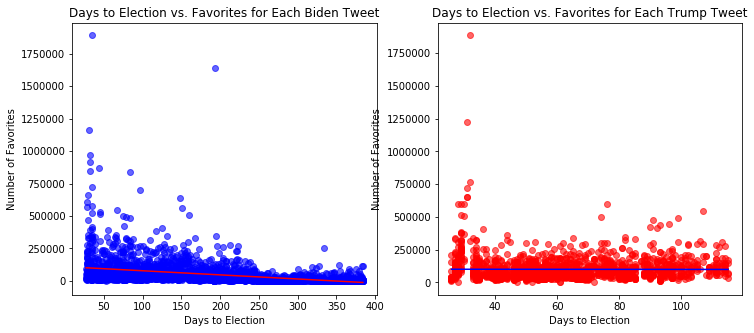

Biden regression coefficient: -316.70
Biden test statistic for regression slope: -21.41
Biden p-value for regression slope test: 0.000
Trump regression coefficient: -16.27
Trump test statistic for regression slope: -0.15
Trump p-value for regression slope test: 0.881


/Users/sunil/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [181]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

b_days_favorites_model = linear_model.LinearRegression().fit(biden[["days_to_election"]], biden["favourite"])
b_days_favorites_predict = b_days_favorites_model.predict(biden[["days_to_election"]])

ax1.scatter(biden["days_to_election"], biden["favourite"], alpha = 0.6, color = "blue")
ax1.plot(biden["days_to_election"], b_days_favorites_predict, c = "red")
ax1.set_title("Days to Election vs. Favorites for Each Biden Tweet")
ax1.set_xlabel("Days to Election")
ax1.set_ylabel("Number of Favorites")

t_days_favorites_model = linear_model.LinearRegression().fit(trump[["days_to_election"]], trump["favourite"])
t_days_favorites_predict = t_days_favorites_model.predict(trump[["days_to_election"]])

ax2.scatter(trump["days_to_election"], trump["favourite"], alpha = 0.6, color = "red")
ax2.plot(trump["days_to_election"], t_days_favorites_predict, c = "blue")
ax2.set_title("Days to Election vs. Favorites for Each Trump Tweet")
ax2.set_xlabel("Days to Election")
ax2.set_ylabel("Number of Favorites")

plt.show()

b_days_favorites_est = sm.OLS(biden["favourite"], sm.add_constant(biden[["days_to_election"]]))
b_days_favorites_est2 = b_days_favorites_est.fit()
print("Biden regression coefficient: " + "{:.2f}".format(b_days_favorites_est2.params[1]))
print("Biden test statistic for regression slope: " + "{:.2f}".format(b_days_favorites_est2.tvalues[1]))
print("Biden p-value for regression slope test: " + "{:.3f}".format(b_days_favorites_est2.pvalues[1]))

t_days_favorites_est = sm.OLS(trump["favourite"], sm.add_constant(trump[["days_to_election"]]))
t_days_favorites_est2 = t_days_favorites_est.fit()
print("Trump regression coefficient: " + "{:.2f}".format(t_days_favorites_est2.params[1]))
print("Trump test statistic for regression slope: " + "{:.2f}".format(t_days_favorites_est2.tvalues[1]))
print("Trump p-value for regression slope test: " + "{:.3f}".format(t_days_favorites_est2.pvalues[1]))

#### Explanation

The graphs above show the number of favorites that each Biden and Trump tweet received and when the tweet was posted. These graphs show some outliers for both Biden and Trump, with a few of their tweets each receiving more than 1 million favorites. Still, most Biden and Trump tweets received 500,000 or less favroites. The least-squares regression lines have negative slopes for both Biden's and Trump's tweets, which indicates that more people liked their tweets as the election drew nearer. Specifically, with each passing day Biden's tweets are expected to receive about 317 more favorites than the previous day, and Trump's tweets are expected to receive about 16 more favorites than the previous day leading up to the election. It is interesting that Biden's tweets became more popular at a faster rate than Trump's tweets, and that only the slope of the regression line for Biden's tweets is significant at the alpha = 0.05 level (P < 0.05). One possible explanation for this is that because Trump was president during the study, his candidacy was not as exciting as Joe Biden's. This explanation could explain why the earliest tweets we sampled from Biden have far fewer favorites than his tweets from closer to the election.

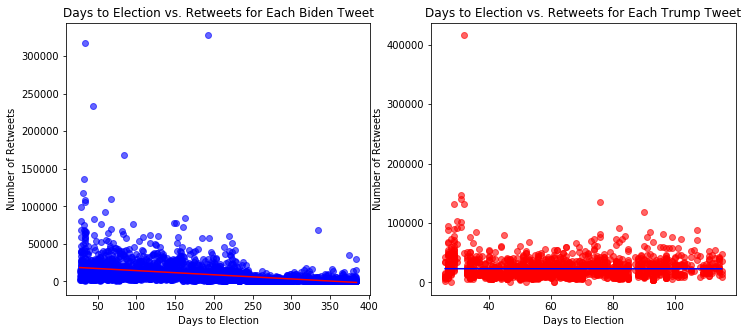

Biden regression coefficient: -55.56
Biden test statistic for regression slope: -22.83
Biden p-value for regression slope test: 0.000
Trump regression coefficient: -1.89
Trump test statistic for regression slope: -0.09
Trump p-value for regression slope test: 0.929


/Users/sunil/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [182]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

b_days_retweets_model = linear_model.LinearRegression().fit(biden[["days_to_election"]], biden["retweets"])
b_days_retweets_predict = b_days_retweets_model.predict(biden[["days_to_election"]])

ax1.scatter(biden["days_to_election"], biden["retweets"], alpha = 0.6, color = "blue")
ax1.plot(biden["days_to_election"], b_days_retweets_predict, c = "red")
ax1.set_title("Days to Election vs. Retweets for Each Biden Tweet")
ax1.set_xlabel("Days to Election")
ax1.set_ylabel("Number of Retweets")

t_days_retweets_model = linear_model.LinearRegression().fit(trump[["days_to_election"]], trump["retweets"])
t_days_retweets_predict = t_days_retweets_model.predict(trump[["days_to_election"]])

ax2.scatter(trump["days_to_election"], trump["retweets"], alpha = 0.6, color = "red")
ax2.plot(trump["days_to_election"], t_days_retweets_predict, c = "blue")
ax2.set_title("Days to Election vs. Retweets for Each Trump Tweet")
ax2.set_xlabel("Days to Election")
ax2.set_ylabel("Number of Retweets")

plt.show()

b_days_retweets_est = sm.OLS(biden["retweets"], sm.add_constant(biden[["days_to_election"]]))
b_days_retweets_est2 = b_days_retweets_est.fit()
print("Biden regression coefficient: " + "{:.2f}".format(b_days_retweets_est2.params[1]))
print("Biden test statistic for regression slope: " + "{:.2f}".format(b_days_retweets_est2.tvalues[1]))
print("Biden p-value for regression slope test: " + "{:.3f}".format(b_days_retweets_est2.pvalues[1]))

t_days_retweets_est = sm.OLS(trump["retweets"], sm.add_constant(trump[["days_to_election"]]))
t_days_retweets_est2 = t_days_retweets_est.fit()
print("Trump regression coefficient: " + "{:.2f}".format(t_days_retweets_est2.params[1]))
print("Trump test statistic for regression slope: " + "{:.2f}".format(t_days_retweets_est2.tvalues[1]))
print("Trump p-value for regression slope test: " + "{:.3f}".format(t_days_retweets_est2.pvalues[1]))

#### Explanation

The graphs above show the number of retweets that each Biden and Trump tweet received and when the tweet was posted. These graphs show some outliers for both Biden and Trump, with a few of their tweets each receiving more than 100,000 retweets. Still, most Biden and Trump tweets received 50,000 or less retweets. The least-squares regression lines have negative slopes for both Biden's and Trump's tweets, which indicates that more people retweeted their tweets as the election drew nearer. Specifically, with each passing day Biden's tweets are expected to receive about 56 more retweets than the previous day, and Trump's tweets are expected to receive about 2 more retweets than the previous day leading up to the election. It is interesting that Biden's tweets grew in popularity at a faster rate than Trump's tweets, and that only the slope of the regression line for Biden's tweets is significant at the alpha = 0.05 level (P < 0.05). Like with the analysis of the number of favorites each tweet received, one possible explanation for this is that because Trump was president during the study his candidacy was not as exciting as Joe Biden's. This explanation could explain why the earliest tweets we sampled from Biden have far fewer retweets than his tweets from closer to the election.

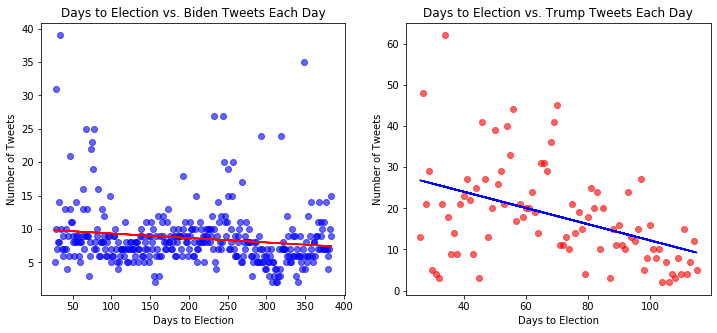

Biden regression coefficient: -0.01
Biden test statistic for regression slope: -2.88
Biden p-value for regression slope test: 0.004
Trump regression coefficient: -0.20
Trump test statistic for regression slope: -4.48
Trump p-value for regression slope test: 0.000


/Users/sunil/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [183]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

b_days_tweets_model = linear_model.LinearRegression().fit(bidenbyday[["days_to_election"]], bidenbyday["tweets_each_day"])
b_days_tweets_predict = b_days_tweets_model.predict(bidenbyday[["days_to_election"]])
ax1.scatter(bidenbyday["days_to_election"], bidenbyday["tweets_each_day"], alpha = 0.6, color = "blue")
ax1.plot(bidenbyday["days_to_election"], b_days_tweets_predict, c = "red")
ax1.set_title("Days to Election vs. Biden Tweets Each Day")
ax1.set_xlabel("Days to Election")
ax1.set_ylabel("Number of Tweets")

t_days_tweets_model = linear_model.LinearRegression().fit(trumpbyday[["days_to_election"]], trumpbyday["tweets_each_day"])
t_days_tweets_predict = t_days_tweets_model.predict(trumpbyday[["days_to_election"]])
ax2.scatter(trumpbyday["days_to_election"], trumpbyday["tweets_each_day"], alpha = 0.6, color = "red")
ax2.plot(trumpbyday["days_to_election"], t_days_tweets_predict, c = "blue")
ax2.set_title("Days to Election vs. Trump Tweets Each Day")
ax2.set_xlabel("Days to Election")
ax2.set_ylabel("Number of Tweets")

plt.show()

b_days_tweets_est = sm.OLS(bidenbyday["tweets_each_day"], sm.add_constant(bidenbyday[["days_to_election"]]))
b_days_tweets_est2 = b_days_tweets_est.fit()
print("Biden regression coefficient: " + "{:.2f}".format(b_days_tweets_est2.params[1]))
print("Biden test statistic for regression slope: " + "{:.2f}".format(b_days_tweets_est2.tvalues[1]))
print("Biden p-value for regression slope test: " + "{:.3f}".format(b_days_tweets_est2.pvalues[1]))

t_days_tweets_est = sm.OLS(trumpbyday["tweets_each_day"], sm.add_constant(trumpbyday[["days_to_election"]]))
t_days_tweets_est2 = t_days_tweets_est.fit()
print("Trump regression coefficient: " + "{:.2f}".format(t_days_tweets_est2.params[1]))
print("Trump test statistic for regression slope: " + "{:.2f}".format(t_days_tweets_est2.tvalues[1]))
print("Trump p-value for regression slope test: " + "{:.3f}".format(t_days_tweets_est2.pvalues[1]))


#### Explanation

The graphs above show the number of tweets Biden and Trump posted each day leading up to the electoin. These graphs show some outliers for both Biden and Trump when they had particularly active days on social media. One interesting feature of these graphs is that it is clear Trump is a more active tweeter than Biden based on his high number of tweets each day. The least-squares regression lines have negative slopes for both Biden's and Trump's tweets, which indicates that Biden and Trump were tweeting more as the election drew nearer. Specifically, with each passing day Biden's is expected to post about 0.01 more tweets than the previous day, and Trump's is expected to tweet about 0.20 more than the previous day leading up to the election. Both Biden's and Trump's increasing tweeting frequency is significant at the alpha = 0.05 level (P < 0.05), which suggests that Biden and Trump truly were tweeting more as the election drew nearer

# Optional Analysis

In [185]:
from collections import Counter 
from string import punctuation
  
allbidenwords = ""

#concatenate texts in all of biden's post into one string, making them all lowercase
for i in range(len(biden)):
    allbidenwords+=biden['full_text'][i].lower()

#transforms the concatenated string into a list of all the words in the string
allbidenwords2 = allbidenwords.split()

#download the nltk packages – action required running this code: go to Corpora, and download "stopwords"
import nltk

from nltk.corpus import stopwords

#obtain the english stopwords

stopwords = stopwords.words('english')

#create and add our own list of english stopwords

additionalstopwords=['',"—","-","need","get","make","every","one","us","take","it’s","it.","we're","i'll","i'm","let","can't","going","would"]

for i in range(len(additionalstopwords)):
    stopwords.append(additionalstopwords[i])
    
#remove all leading and trailing punctuations of biden's words
for i in range(len(allbidenwords2)):
    allbidenwords2[i]=allbidenwords2[i].strip(punctuation)
    
#create a new counter object which we will use to count the words and their frequencies

Counter = Counter(allbidenwords2) 

#returns the top-200 (leave a large enough margin) most freqeunt words and their count
bidenmostfrequentwords = Counter.most_common(200)

#filter out the english stopwords from the list of words

bidenmostfrequentwords = [(word, count) for word, count in bidenmostfrequentwords if word not in stopwords]
  
#print only the top-30 most frequent words and their count
print(bidenmostfrequentwords[:30]) 


[('trump', 796), ('president', 737), ('donald', 499), ('nation', 346), ('american', 335), ('country', 306), ('people', 289), ('day', 271), ('time', 241), ('crisis', 220), ('care', 214), ('health', 212), ('help', 211), ('together', 207), ('today', 206), ('america', 197), ('americans', 183), ('work', 176), ('years', 175), ('white', 170), ('back', 168), ('know', 157), ('campaign', 151), ('better', 148), ('house', 143), ('covid-19', 142), ('world', 137), ('like', 137), ('must', 134), ('never', 132)]


In [187]:
from collections import Counter 
from string import punctuation

alltrumpwords = ""

#concatenate texts in all of trump's post into one string, making them all lowercase
for i in range(len(trump)):
    alltrumpwords+=trump['full_text'][i].lower()

#transforms the concatenated string into a list of all the words in the string
alltrumpwords2 = alltrumpwords.split()

#download the nltk packages – action required running this code: go to Corpora, and download "stopwords"
import nltk

#nltk.download() <--unhighlight this code to do the installation

from nltk.corpus import stopwords

#obtain the english stopwords

stopwords = stopwords.words('english')

#create and add our own list of english stopwords

additionalstopwords=['',"—","-","need","get","make","every","one","us","take","it’s","it.","we're","i'll","i'm","let","can't","going","would"]

for i in range(len(additionalstopwords)):
    stopwords.append(additionalstopwords[i])
    
#remove all leading and trailing punctuations of trump's words
for i in range(len(alltrumpwords2)):
    alltrumpwords2[i]=alltrumpwords2[i].strip(punctuation)
    
#create a new counter object which we will use to count the words and their frequencies

Counter = Counter(alltrumpwords2) 

#returns the top-200 (leave a large enough margin) most freqeunt words and their count
trumpmostfrequentwords = Counter.most_common(200)

#filter out the english stopwords from the list of words

trumpmostfrequentwords = [(word, count) for word, count in trumpmostfrequentwords if word not in stopwords]
  
#print only the top-30 most frequent words and their count
print(trumpmostfrequentwords[:30])

[('great', 200), ('amp', 194), ('biden', 131), ('people', 120), ('joe', 99), ('news', 94), ('fake', 88), ('never', 84), ('vote', 78), ('country', 74), ('big', 73), ('even', 71), ('total', 70), ('democrats', 69), ('president', 69), ('many', 65), ('left', 64), ('like', 61), ('new', 61), ('want', 60), ('back', 60), ('complete', 59), ('maga', 58), ('endorsement', 58), ('thank', 57), ('years', 56), ('state', 56), ('election', 56), ('win', 53), ('radical', 53)]


Next, we sentiment code the top 30 words from each candidates into three categories: positive, neutral, and negative.

In [188]:
print("Biden's top-30 most frequent words are:\n")
print(bidenmostfrequentwords[:30])
print("\nTrump's top-30 most frequent words are:\n")
print(trumpmostfrequentwords[:30])

Biden's top-30 most frequent words are:

[('trump', 796), ('president', 737), ('donald', 499), ('nation', 346), ('american', 335), ('country', 306), ('people', 289), ('day', 271), ('time', 241), ('crisis', 220), ('care', 214), ('health', 212), ('help', 211), ('together', 207), ('today', 206), ('america', 197), ('americans', 183), ('work', 176), ('years', 175), ('white', 170), ('back', 168), ('know', 157), ('campaign', 151), ('better', 148), ('house', 143), ('covid-19', 142), ('world', 137), ('like', 137), ('must', 134), ('never', 132)]

Trump's top-30 most frequent words are:

[('great', 200), ('amp', 194), ('biden', 131), ('people', 120), ('joe', 99), ('news', 94), ('fake', 88), ('never', 84), ('vote', 78), ('country', 74), ('big', 73), ('even', 71), ('total', 70), ('democrats', 69), ('president', 69), ('many', 65), ('left', 64), ('like', 61), ('new', 61), ('want', 60), ('back', 60), ('complete', 59), ('maga', 58), ('endorsement', 58), ('thank', 57), ('years', 56), ('state', 56), ('el

In [189]:
bidenpositive=["nation","american","country","people","care","health","help","together","america","americans","better","like"]
bidenneutral=["trump","president","donald","day","time","today","work","years","white","back","know","campaign","house","covid-19","world","must"]
bidennegative=["crisis","never"]

print(len(bidenpositive))
print(len(bidenneutral))
print(len(bidennegative))

12
16
2


In [190]:
trumppositive=["great","people","vote","country","big","many","like","new","want","complete","maga","endorsement","thank","win"]
trumpneutral=["amp","biden","joe","news","even","total","democrats","president","left","back","years","state","election"]
trumpnegative=["fake","never","radical"]

print(len(trumppositive))
print(len(trumpneutral))
print(len(trumpnegative))

14
13
3


As shown above, 12 out of the top-30 most frequently used words by Biden are positive, 16 are neutral, and 2 are negative. On the other hand, 14 out of the top-30 most frequently used words by trump are positive, 13 are neutral, and 3 are negative. This mirrors our results of sentiment analysis, which found that Trump had a lot more positive tweets than Biden (as seen through 14 > 12) as well as more negative tweets than Biden (as seen through 3 > 2). This adds further credibility to our findings that Trump's results seem more polarized and subjective than Biden's, as demonstrated in the polarity vs subjectivity plots.

# Logistic Regression Analysis
### Research Question: Does the time of day impact tweet behavior? 
#### null hypothesis : time of day does not impact amount of favorites recieved by a tweet <- check for both trump and biden
* we use the time of day to predict whether a tweet is heavily liked (recieve more than 50,000 favorites)

In [191]:
from sklearn.linear_model import LogisticRegression
def liked(x):
    if x > 50000:
        return 1 
    else:
        return 0 
biden['loved'] = biden['favourite'].map(liked)
trump['loved'] = trump['favourite'].map(liked)

def logit(x):
    return np.exp(x) / (np.exp(x) + 1)

def log_reg(biden, trump):
    x = 0
    subplot = [121, 122]
    title = ['Biden', 'Trump']
    color = ['blue', 'red']
    df = [biden, trump]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax = [ax1, ax2]
    for i in df: 
        model = LogisticRegression(solver = "lbfgs").fit(i[['hour']], i['loved'])
        x_values = np.linspace(0, 23, 100) 
        ax[x].scatter(i['hour'], i['loved'] + np.random.normal(0, 0.05, size=len(i)), alpha = 0.1, color = color[x])
        ax[x].plot(x_values, logit(x_values * model.coef_[0,0] + model.intercept_[0]), color = color[x])
        ax[x].set_title(title[x])
        ax[x].set_xlabel("hour")
        ax[x].set_ylabel("probability of loved tweet")
        
        x +=1

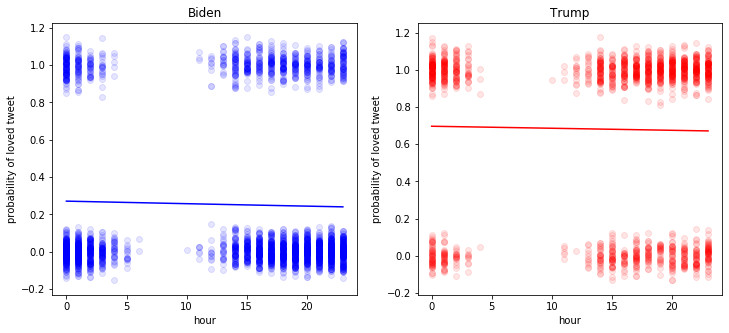

In [192]:
log_reg(biden, trump)

From the logistic regression, there does not seem to be a strong correlation between the time a tweet is posted (hour of the day) and the probability of recieving more than 100,000 favorites for that tweet for either Trump or Biden. 

# Cluster Analysis 
* Initially, we were planning on doing a cluster analysis using time of day as a predictor. However, after performing a logistic regression analysis using time of day as a predictor of a super liked tweet, we found that time of day would not be a good predictor. Additionally, when we added time of day as a parameter in the clustering algorithm, it decreased the accuracy substantially. 
* See the appendix section to see graphs that we used to explore if clustering by time would make sense
* We used the KMeans clustering algorithm to build a multiple prediction models to predict a Trump vs Biden tweet.

Actual trump biden distribution: 


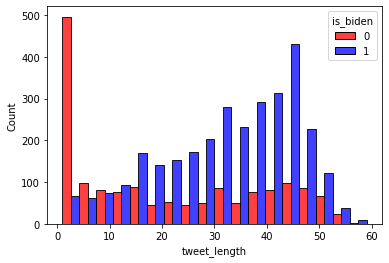

In [193]:
from sklearn.cluster import KMeans
# assign biden tweets a value of 1 and trump tweets value of 0
biden['is_biden'] = 1
trump['is_biden'] = 0

# combine dfs 
combined_dfs = pd.concat([biden,trump], sort = True)

# 1 parameter 
clustering = KMeans(n_clusters = 2, random_state = 15)
cluster_labels = clustering.fit_predict(combined_dfs[['tweet_length']])
combined_dfs['cluster_bylength'] = cluster_labels 

# 2 parameters 
clustering2 = KMeans(n_clusters = 2, random_state = 15)
cluster_labels_fav_len = clustering2.fit_predict(combined_dfs[['tweet_length', 'favourite']])
combined_dfs['cluster_bylength_likes'] = cluster_labels_fav_len

# multiple parameters <- recognize overfitting can occur as more variables are added to prediction algorithm 
clustering3 = KMeans(n_clusters = 2, random_state = 15)
cluster_labels_mult = clustering3.fit_predict(combined_dfs[['tweet_length', 'favourite', 'retweets']])
combined_dfs['cluster_mult'] = cluster_labels_mult

# see mapping of clusters
palette = {0: 'red', 1: 'blue'}
print("Actual trump biden distribution: ")
sns.histplot(x = 'tweet_length', hue = 'is_biden', data = combined_dfs, multiple="dodge", palette = palette)
plt.show()

Prediction model cluster using tweet length as only predictor distribution: 


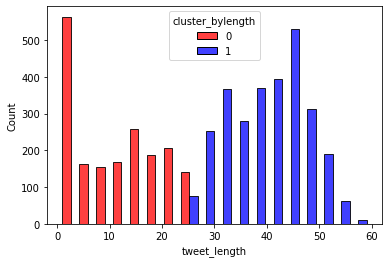

In [194]:
palette = {0: 'red', 1: 'blue'}
print('Prediction model cluster using tweet length as only predictor distribution: ')
sns.histplot(x = 'tweet_length', hue = 'cluster_bylength', data = combined_dfs, multiple="dodge", palette = palette)
plt.show()

In [195]:
# compute accuracy 
combined_dfs = combined_dfs.reset_index(drop = True)

def accuracy(x, col1, col2):
    correct = 0 
    
    for i in range(len(x)):
        
        if x[col1][i] == 1 and x[col2][i] == 1:
            correct += 1
        elif x[col1][i] == 0 and x[col2][i] == 0:
            correct += 1
        else: 
            correct += 0
    return (correct / len(x)) * 100

print('Accuracy of clustering prediction algorthim using only tweet length as predictor:')
print("{}%".format(accuracy(combined_dfs, 'is_biden', 'cluster_bylength')))
print('\n')
# subtracted from 100, because the clusters mapped to opposite values in is_biden 
print('Accuracy of clustering prediction algorithm using favorite count and tweet length as predictors:')
print("{}%".format(100-accuracy(combined_dfs, 'is_biden', 'cluster_bylength_likes')))
print("\n")
print("Accuracy of clustering prediction algorithm using retweet count, favorite count and tweet length as predictors:")
print("{}%".format(100-accuracy(combined_dfs, 'is_biden', 'cluster_mult')))


Accuracy of clustering prediction algorthim using only tweet length as predictor:
67.98124067363037%


Accuracy of clustering prediction algorithm using favorite count and tweet length as predictors:
66.76614794286932%


Accuracy of clustering prediction algorithm using retweet count, favorite count and tweet length as predictors:
67.08590918780644%


KMeans clustering prediction model solidifies our previous inferences. It was very hard to differentiate Biden and Trump tweets by comparing favorite and retweet counts. However, the tweeet length of Biden and Trump tweets did differ as shown by the histogram above (Trump has many short tweets). The model reflects this. The tweet length is the strongest predictor and adding extra predictors did not impact the model's accuracy. By relying on tweet length as the main predictor, however, the model is not able to predict lengthy Trump tweets and short Biden tweets. Thus, the model is ultimately not very informative. To improve the model, I recommend using predictors that account for the content of the tweet.

# Questions for Reviewers 
* Would normalization help in any part of this analysis?
* How to fit a binomal regression / fit? I think this could benefit the analysis for time of day vs probability of loved tweet
* Is there any way you can think of to make the days to election vs. words graphs more visually appealing?

# Appendix 


# Extra Exploratory Data Analysis 

In [34]:
# Check to see if the conversion preserved the date in the order we expect. 
# change instances of "created_at" with "date" and biden or trump with biden / trump 

print("The most recent tweet we have from Biden was tweeted on: " + str(biden["date"][0]))
print("Biden most recent tweet's year according to Python: " + str(biden["date"][0].year))
print("Biden most recent tweet's month according to Python: " + str(biden["date"][0].month))
print("Biden most recent tweet's day according to Python: " + str(biden["date"][0].day))
print("It appears the conversion was successful")

The most recent tweet we have from Biden was tweeted on: 2020-10-07
Biden most recent tweet's year according to Python: 2020
Biden most recent tweet's month according to Python: 10
Biden most recent tweet's day according to Python: 7
It appears the conversion was successful


In [35]:
# # Check to see if we can determine how many days pass between two dates

print("The most recent tweet we have from Biden was tweeted on: " + str(biden["created_at"][0]))
print("The oldest tweet we have from Biden was tweeted on: " + 
      str(biden["created_at"][len(biden["created_at"])-1]))
test_start = biden["created_at"][len(biden["created_at"])-1]
test_end = biden["created_at"][0]
test_start_date = date(test_start.year, test_start.month, test_start.day)
test_end_date = date(test_end.year, test_end.month, test_end.day)
delta = test_end_date - test_start_date
print("Biden's tweets span " + str(delta.days) + " days")
print("2020 is a leap year with 366 days, so the result above is correct.")

# # Source: https://www.w3resource.com/python-exercises/python-basic-exercise-14.php

The most recent tweet we have from Biden was tweeted on: 2020-10-07 02:12:00
The oldest tweet we have from Biden was tweeted on: 2019-10-16 02:35:02
Biden's tweets span 357 days
2020 is a leap year with 366 days, so the result above is correct.


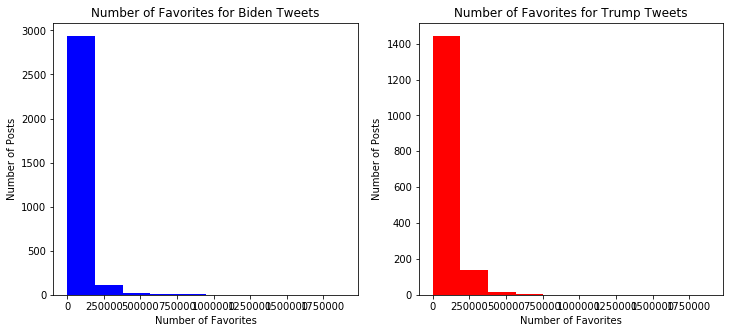

In [36]:
#Favorites <- only show the log scale, doesn't make sense to display this graph 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(biden['favourite'], color = "blue")
ax1.set_title("Number of Favorites for Biden Tweets")
ax1.set_xlabel("Number of Favorites")
ax1.set_ylabel("Number of Posts")

ax2.hist(trump['favourite'], color = "red")
ax2.set_title("Number of Favorites for Trump Tweets")
ax2.set_xlabel("Number of Favorites")
ax2.set_ylabel("Number of Posts")

plt.show()

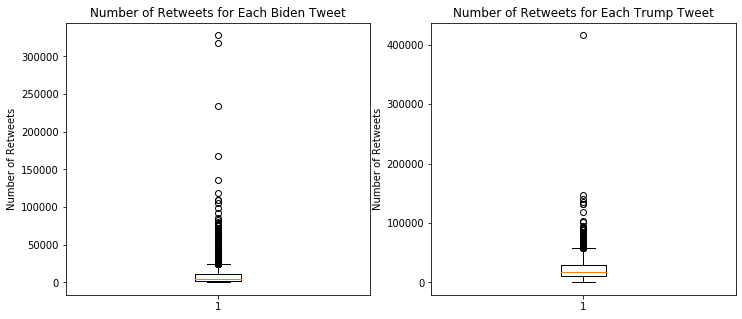

In [37]:
# Retweets 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.boxplot(biden['retweets'])
ax1.set_title("Number of Retweets for Each Biden Tweet")
ax1.set_ylabel("Number of Retweets")

ax2.boxplot(trump['retweets'])
ax2.set_title("Number of Retweets for Each Trump Tweet")
ax2.set_ylabel("Number of Retweets")

plt.show()

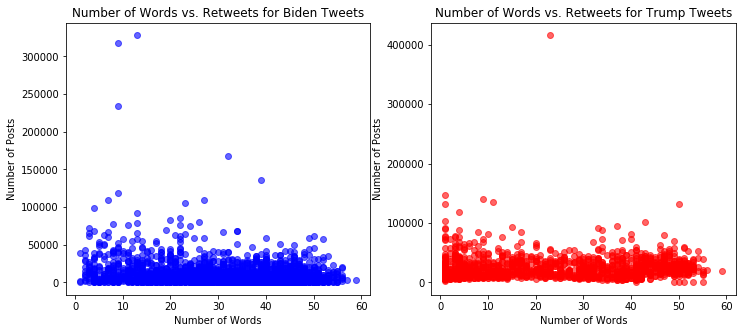

In [38]:
# Number of Words vs. Retweets 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x = biden['tweet_length'], y = biden['retweets'], alpha = 0.6, color="blue")
ax1.set_title("Number of Words vs. Retweets for Biden Tweets")
ax1.set_xlabel("Number of Words")
ax1.set_ylabel("Number of Posts")

ax2.scatter(x = trump['tweet_length'], y = trump['retweets'], alpha = 0.6, color="red")
ax2.set_title("Number of Words vs. Retweets for Trump Tweets")
ax2.set_xlabel("Number of Words")
ax2.set_ylabel("Number of Posts")

plt.show()

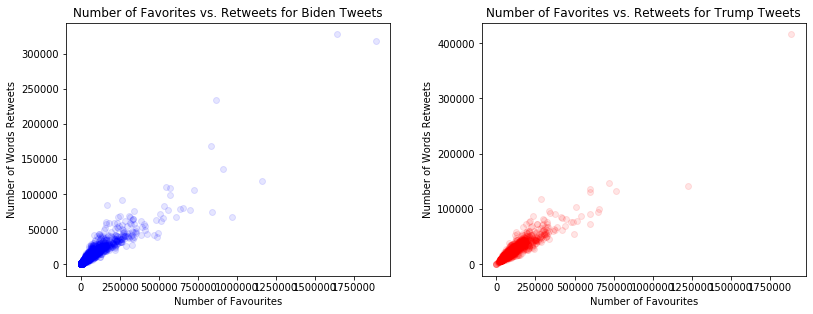

In [39]:
# Number of Favorites vs. Retweets <- non-log version

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x = 'favourite', y = 'retweets', data = biden, alpha = 0.1, color="blue")
ax1.set_title("Number of Favorites vs. Retweets for Biden Tweets")
ax1.set_xlabel("Number of Favourites")
ax1.set_ylabel("Number of Words Retweets")

ax2.scatter(x = 'favourite', y = 'retweets', data = trump, alpha = 0.1, color="red")
ax2.set_title("Number of Favorites vs. Retweets for Trump Tweets")
ax2.set_xlabel("Number of Favourites")
ax2.set_ylabel("Number of Words Retweets")

fig.tight_layout(pad=3.0)
plt.show()

## Exploratory Data Analysis for Cluster Analysis:

Biden: 
evening      1343
night        1196
afternoon     518
morning        27
Name: time_of_day, dtype: int64


Trump: 
night        555
evening      476
afternoon    409
morning      167
Name: time_of_day, dtype: int64


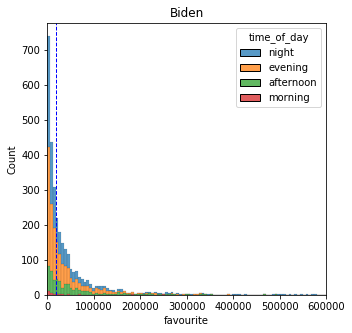

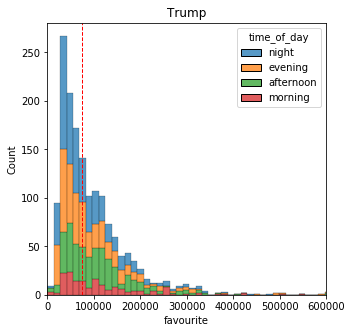

In [40]:
print("Biden: ")
print(biden.time_of_day.value_counts()) 
print('\n')
print("Trump: ")
print(trump.time_of_day.value_counts())

# blue dashed line = biden median value for favorites recieved 
# red dashed line = trump median value for favorites recieved 
plt.figure(figsize = (5,5))
sns.histplot(x="favourite", hue="time_of_day", multiple = "stack", data = biden)
plt.xlim(left = 0, right = 600000)
plt.title("Biden")
plt.axvline(biden['favourite'].median(), color='blue', linestyle='dashed', linewidth=1)

plt.figure(figsize = (5,5))
sns.histplot(x="favourite", hue="time_of_day", multiple = "stack", data = trump)
plt.xlim(left = 0, right = 600000)
plt.title("Trump")
plt.axvline(trump['favourite'].median(), color='red', linestyle='dashed', linewidth=1)

plt.show()

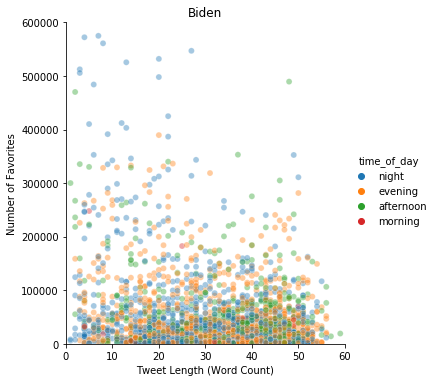

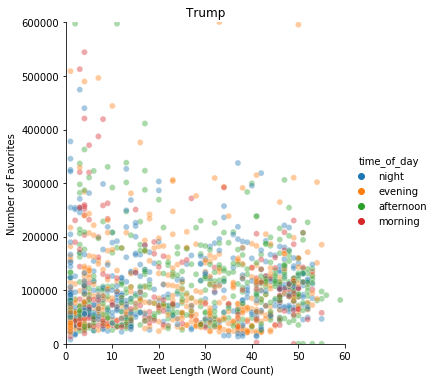

In [41]:
# does not seem to be a relationship between tweet length and number of favorites recieved 
# trump has many tweets that are a single hyperlink to another tweet, which is why he has many tweets of length = 1
sns.relplot(x = "tweet_length", y = "favourite", hue = "time_of_day", alpha = 0.4, data = biden)
plt.xlabel("Tweet Length (Word Count)")
plt.ylabel("Number of Favorites")
plt.title("Biden")
plt.xlim(left = 0, right = 60)
plt.ylim(bottom = 0, top = 600000)

sns.relplot(x = "tweet_length", y = "favourite", hue = "time_of_day", alpha = 0.4, data = trump)
plt.xlabel("Tweet Length (Word Count)")
plt.ylabel("Number of Favorites")
plt.title("Trump")
plt.xlim(left = 0, right = 60)
plt.ylim(bottom = 0, top = 600000)
plt.show()